## Digit classification with pre-trained GoogleNet model

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Imports
import os, warnings
import pandas as pd
import numpy as np

## Mount to the data drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/digit_recognizer/data"

# Import the data
 - separate the feature data and label data
 - for training data, we need to separate it further into training and verification data

In [4]:
data = pd.read_csv(data_path + "/train.csv")
print("train data:")
display(data.head())

label = data.iloc[:, 0]
data = data.iloc[:, 1:]

data_test = pd.read_csv(data_path + "/test.csv")
print("test data:")
display(data_test.head())

train data:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


test data:


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
display(data.shape)
display(data_test.shape)

(42000, 784)

(28000, 784)

## Processing the image data
 - normalize the data into the range 0-1
 - show some sample images in matplotlib

In [5]:
dataNorm = data.to_numpy()
normalize_max = np.max(dataNorm)

dataNorm = dataNorm / normalize_max
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

dataNorm_test = data_test.to_numpy()
dataNorm_test = dataNorm_test / normalize_max
dataNorm_test = dataNorm_test.reshape(dataNorm_test.shape[0],1,28,28)

train images:


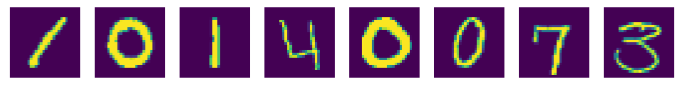

test images:


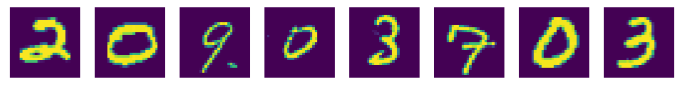

In [30]:
plt.figure(figsize=(12,3))
print("train images:")

for i in range(8):
    image = dataNorm[i,:]
    plt.subplot(1, 8, i+1)
    plt.imshow(np.squeeze(image))
    plt.axis('off')
plt.show()

plt.figure(figsize=(12,3))
print("test images:")
for i in range(8):
    image = dataNorm_test[i,:]
    plt.subplot(1, 8, i+1)
    plt.imshow(np.squeeze(image))
    plt.axis('off')
plt.show()

# Padding the batch of images
Since many pre-trained models require the minimum image size of 32*32, we need to pad the original images of 28*28 to meet the pre-trained model requirement.

(42000, 1, 32, 32)

(28000, 1, 32, 32)

train images:


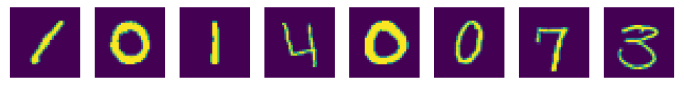

test images:


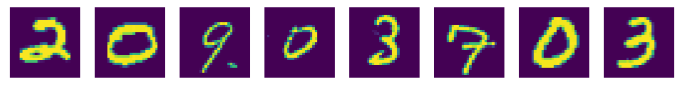

In [6]:
padded_images = np.pad(dataNorm, pad_width = ((0,0),(0,0), (2,2), (2,2)), mode='edge')
padded_images_test = np.pad(dataNorm_test, pad_width = ((0,0),(0,0), (2,2), (2,2)), mode='edge')
display(padded_images.shape)
display(padded_images_test.shape)

plt.figure(figsize=(12,3))
print("train images:")

for i in range(8):
    image = padded_images[i,:]
    plt.subplot(1, 8, i+1)
    plt.imshow(np.squeeze(image))
    plt.axis('off')
plt.show()

plt.figure(figsize=(12,3))
print("test images:")
for i in range(8):
    image = dataNorm_test[i,:]
    plt.subplot(1, 8, i+1)
    plt.imshow(np.squeeze(image))
    plt.axis('off')
plt.show()

# Create train/verification/test groups using DataLoader

In [7]:
# Step 1: convert to tensor
dataT   = torch.tensor(padded_images).float()
labelT = torch.tensor(label).long()

dataT_test = torch.tensor(padded_images_test).float()

# Step 2: use scikitlearn to split the data
train_data, veri_data, train_labels, veri_labels = train_test_split(dataT, labelT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
veri_data  = TensorDataset(veri_data,veri_labels)
test_data = TensorDataset(dataT_test)

# Step 4: translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
veri_loader  = DataLoader(veri_data, batch_size=len(veri_data), shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True, drop_last=True)

## Confirm the data size and data type

In [8]:
# check size (should be images X channels X width X height)
display("training feature shape:", train_loader.dataset.tensors[0].shape)
display("training label shape:", train_loader.dataset.tensors[1].shape)
display("verification feature shape:", veri_loader.dataset.tensors[0].shape)
display("verification label shape:", veri_loader.dataset.tensors[1].shape)
display("test feature shape:", test_loader.dataset.tensors[0].shape)

'training feature shape:'

torch.Size([37800, 1, 32, 32])

'training label shape:'

torch.Size([37800])

'verification feature shape:'

torch.Size([4200, 1, 32, 32])

'verification label shape:'

torch.Size([4200])

'test feature shape:'

torch.Size([28000, 1, 32, 32])

In [ ]:
'''
Some notes:
If you were wondering whether you should implement dropout in a convolutional network, now you know.
Only use dropout on fully-connected layers, and implement batch normalization between convolutions.

see this post for how to apply grayscale images as input:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

use opencv for image transformation: https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image
but we could also use numpy to just simply pad an image if its size is too small:
https://stackoverflow.com/questions/51650325/how-to-pad-an-image-using-np-pad-in-python

fine-tune the model and freeze the layers selectively:
https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/15
https://stackoverflow.com/questions/57138862/how-do-i-tell-if-i-have-successfully-frozen-or-unfrozen-a-layer-in-keras#:~:text=You%20can%20find%20whether%20a,trainable'%3A%20True%2C%20...

GoogLeNet returns a named tuple and thus behave differently than VGG. See source 9
GoogLeNetOutputs = namedtuple('GoogLeNetOutputs', ['logits', 'aux_logits2', 'aux_logits1'])
see this post: https://discuss.pytorch.org/t/i-want-use-the-googlenet-model-but-something-wrong/65591/2

set model.train() will not influence the freezing parameters
https://stackoverflow.com/questions/69214009/will-pytorch-model-train-influence-freezed-layers

'''

In [9]:
from torchvision.io import read_image
from torchvision.models import GoogLeNet, GoogLeNet_Weights
# from torchvision.models import EfficientNet_B0_Weights, EfficientNet
# from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision import transforms
import torch.nn as nn
# import timm

# Step 1: Initialize model with the best available weights
model = GoogLeNet(init_weights = GoogLeNet_Weights.DEFAULT)

# Step 2: add extra layers to adjust the model structure
model.fc = nn.Sequential(
    nn.Linear(1024, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Linear(256, 10)    # Final prediction fc layer
)

model.conv1 = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=3, stride=1, bias=False),
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    nn.BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
dir(model)

# Unfreeze the parameters of some layers.
Use summary() function to get the model parameter information. In the last section, it also gives the trainable parameter information. Check if it is consistent with your setting.

In [ ]:
# unfreeze some layers
for param in model.parameters():
    param.requires_grad = False

for name, child in model.fc.named_children():
    if name == "0" or name == "2":
        for param in child.parameters():
            param.requires_grad = True

for name, child in model.conv1.named_children():
    if name == "0":
        for param in child.parameters():
            param.requires_grad = True

summary(model, (1, 32, 32))

## Specify the loss function and optimizer

In [14]:
# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=.0001)



## Test the model with one batch

In [15]:
# test the model with one batch
X,y = next(iter(train_loader))

yHat = model(X).logits
y_pred = torch.argmax(yHat,axis=1).float()

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y_pred.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])
 
Loss:
tensor(2.3563, grad_fn=<NllLossBackward0>)


# Create a function that trains the model and show the verification metrics

In [23]:
# a function that trains the model

def function2trainTheModel(model, lossfun, optimizer):

  # number of epochs
  numepochs = 5

  # create a new model
#   net,lossfun,optimizer = model()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    print(f"Epochi {epochi} starts -------")
    # loop over training data batches
    model.train()
    batchAcc  = []
    batchLoss = []

    # model.train()
    # summary(model, (1, 32, 32))
    for k, (X,y) in enumerate(train_loader):
      if k % 500 == 0:
        print(f"Batch {k} ---")

      # forward pass and loss
      yHat = model(X).logits
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    model.eval()
    # summary(model, (1, 32, 32))
    veri_X, veri_y = next(iter(veri_loader)) # extract X,y from test dataloader

    # with torch.no_grad(): # deactivates autograd
    veri_yHat = model(veri_X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(veri_yHat,axis=1)==veri_y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,model


# Run the model and show the results!

In [24]:
trainAcc,testAcc,losses,model = function2trainTheModel(model, lossfun, optimizer)

Epochi 0 starts -------
Batch 0 ---
Batch 500 ---
Epochi 1 starts -------
Batch 0 ---
Batch 500 ---
Epochi 2 starts -------
Batch 0 ---
Batch 500 ---
Epochi 3 starts -------
Batch 0 ---
Batch 500 ---
Epochi 4 starts -------
Batch 0 ---
Batch 500 ---


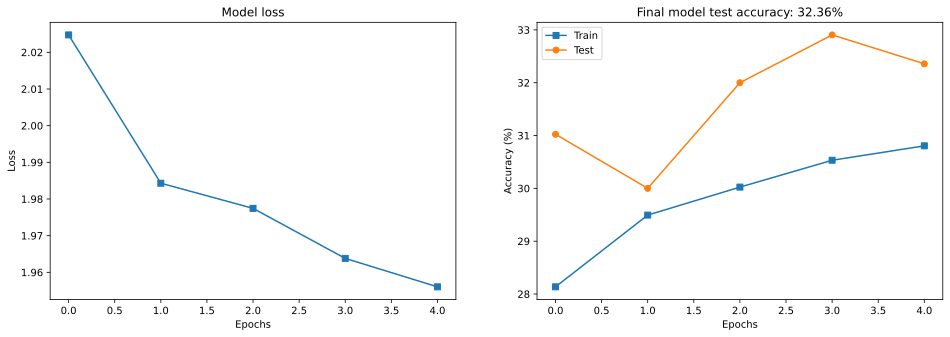

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
model.eval()
test_X = next(iter(test_loader))
with torch.no_grad(): # deactivates autograd
    test_yHat = model(padded_images_test)

print(test_yHat)

In [ ]:
test_result = torch.argmax(test_yHat,axis=1)

In [ ]:
test_data = pd.read_csv(data_path + "/sample_submission.csv")
test_data.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
test_data['Label'] = test_result
test_data.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
test_data.to_csv(data_path + "/claudia_submission.csv", index = False)